In [26]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Get time series data

In [2]:
industrial_production = (
    pdr.DataReader("IPGMFN", "fred", "1988", "2017-12").squeeze().dropna()
)
industrial_production

DATE
1988-01-01     55.6315
1988-02-01     56.8324
1988-03-01     57.5487
1988-04-01     57.7727
1988-05-01     57.8687
                ...   
2017-08-01    100.7360
2017-09-01    100.3586
2017-10-01    101.9040
2017-11-01    100.6590
2017-12-01     99.5281
Name: IPGMFN, Length: 360, dtype: float64

In [3]:
nasdaq = pdr.DataReader("NASDAQCOM", "fred", "1990", "2017-12-31").squeeze().dropna()
nasdaq

DATE
1990-01-02     459.33
1990-01-03     460.90
1990-01-04     459.39
1990-01-05     458.22
1990-01-08     458.71
               ...   
2017-12-22    6959.96
2017-12-26    6936.25
2017-12-27    6939.34
2017-12-28    6950.16
2017-12-29    6903.39
Name: NASDAQCOM, Length: 7056, dtype: float64

## Plot decomposition

In [4]:
components = tsa.seasonal_decompose(industrial_production, model="additive")
ts_df = (
    industrial_production.to_frame("original")
    .assign(trend=components.trend)
    .assign(seasonality=components.seasonal)
    .assign(residual=components.resid)
)
ts_df

original  trend  seasonality  residual
DATE                                              
1988-01-01   55.6315    NaN    -2.090507       NaN
1988-02-01   56.8324    NaN    -0.579679       NaN
1988-03-01   57.5487    NaN     0.747645       NaN
1988-04-01   57.7727    NaN    -0.233705       NaN
1988-05-01   57.8687    NaN     0.192588       NaN
...              ...    ...          ...       ...
2017-08-01  100.7360    NaN     0.908542       NaN
2017-09-01  100.3586    NaN     1.470945       NaN
2017-10-01  101.9040    NaN     1.508397       NaN
2017-11-01  100.6590    NaN     0.088311       NaN
2017-12-01   99.5281    NaN    -1.405991       NaN

[360 rows x 4 columns]

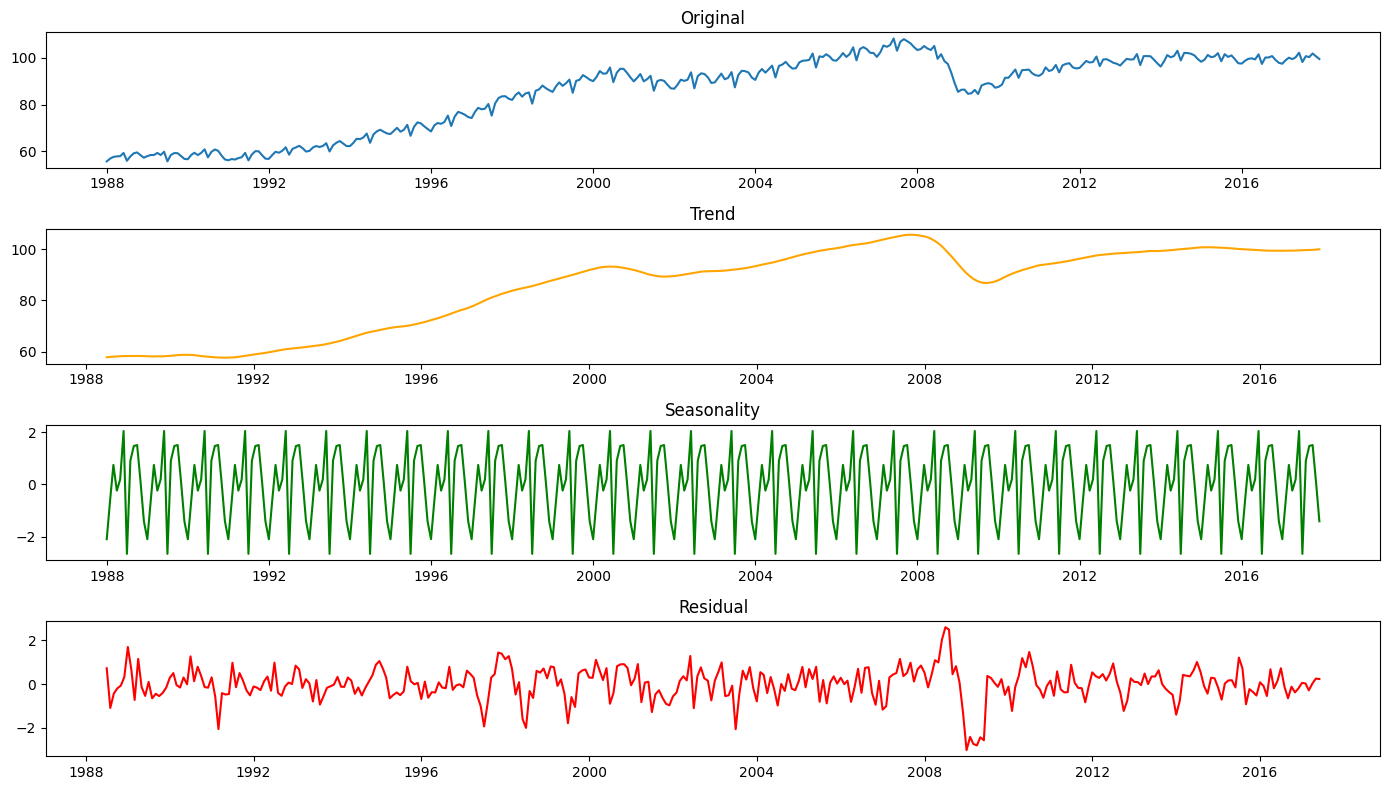

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))
axs[0].plot(ts_df["original"])
axs[0].set_title("Original")
axs[1].plot(ts_df["trend"], color="orange")
axs[1].set_title("Trend")
axs[2].plot(ts_df["seasonality"], color="green")
axs[2].set_title("Seasonality")
axs[3].plot(ts_df["residual"], color="red")
axs[3].set_title("Residual")
plt.tight_layout()

## Log transform

In [6]:
(nasdaq == 0).any(), (industrial_production == 0).any()

(np.False_, np.False_)

In [7]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

## Differencing

In [8]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
nasdaq_log_diff

DATE
1990-01-03    0.003412
1990-01-04   -0.003282
1990-01-05   -0.002550
1990-01-08    0.001069
1990-01-09   -0.004238
                ...   
2017-12-22   -0.000776
2017-12-26   -0.003412
2017-12-27    0.000445
2017-12-28    0.001558
2017-12-29   -0.006752
Name: NASDAQCOM, Length: 7055, dtype: float64

In [9]:
# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()
industrial_production_log_diff

DATE
1989-01-01    0.040001
1989-02-01    0.026613
1989-03-01    0.014085
1989-04-01    0.025199
1989-05-01    0.008367
                ...   
2017-08-01    0.005890
2017-09-01    0.001489
2017-10-01    0.011061
2017-11-01    0.015342
2017-12-01    0.016682
Name: IPGMFN, Length: 348, dtype: float64

## Plots of differenced series

Display Dickey-Fuller test p-values too.

### NASDAQ

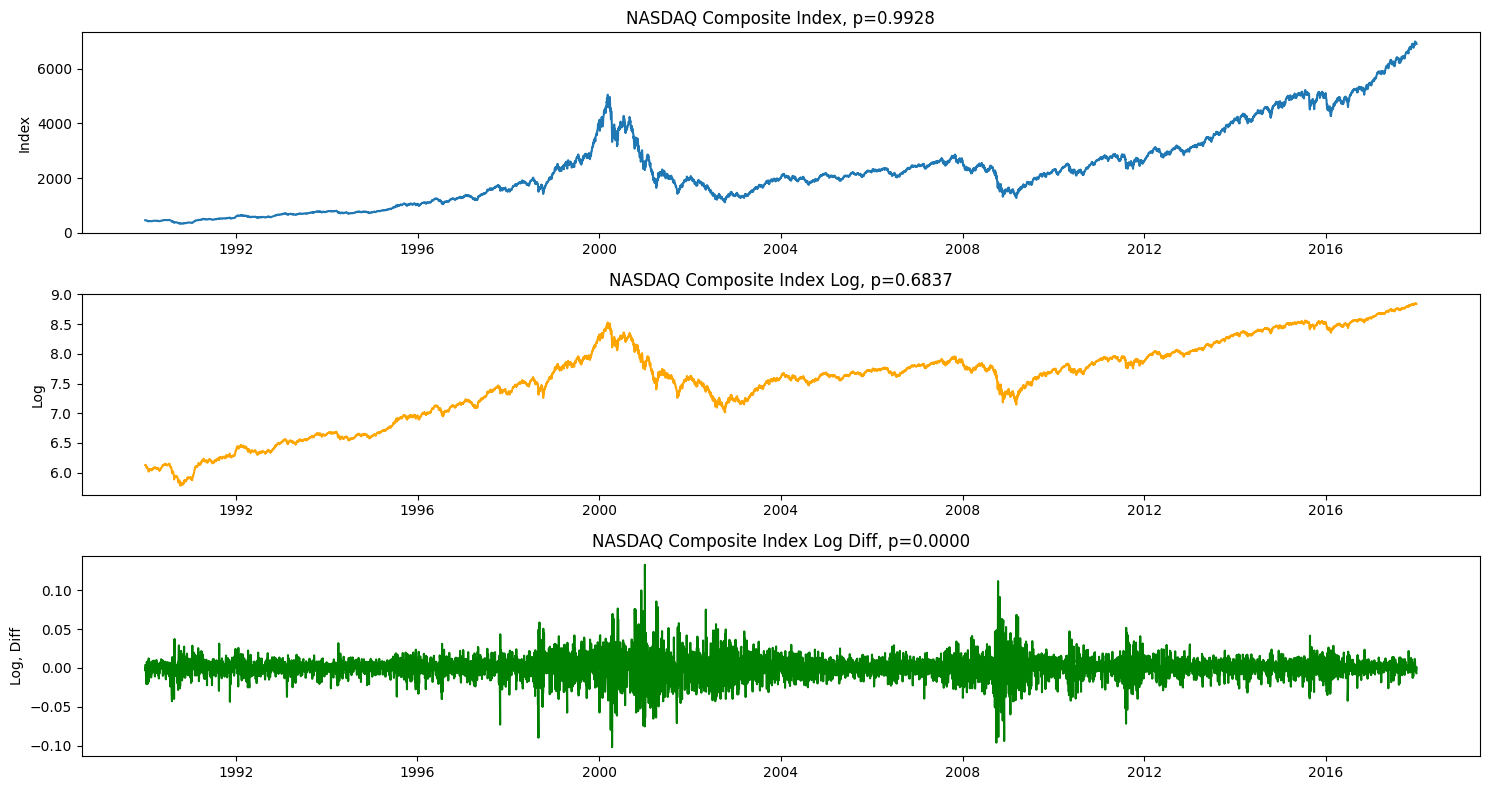

In [10]:
nasdaq_adf_p = tsa.adfuller(nasdaq)[1]
nasdaq_log_adf_p = tsa.adfuller(nasdaq_log)[1]
nasdaq_log_diff_adf_p = tsa.adfuller(nasdaq_log_diff)[1]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axs[0].plot(nasdaq)
axs[0].set_title(f"NASDAQ Composite Index, p={nasdaq_adf_p:.4f}")
axs[0].set_ylabel("Index")
axs[1].plot(nasdaq_log, color="orange")
axs[1].set_title(f"NASDAQ Composite Index Log, p={nasdaq_log_adf_p:.4f}")
axs[1].set_ylabel("Log")
axs[2].plot(nasdaq_log_diff, color="green")
axs[2].set_title(f"NASDAQ Composite Index Log Diff, p={nasdaq_log_diff_adf_p:.4f}")
axs[2].set_ylabel("Log, Diff")
fig.tight_layout()

### Industrial production

Remember it had a 12-month lag for YoY returns.

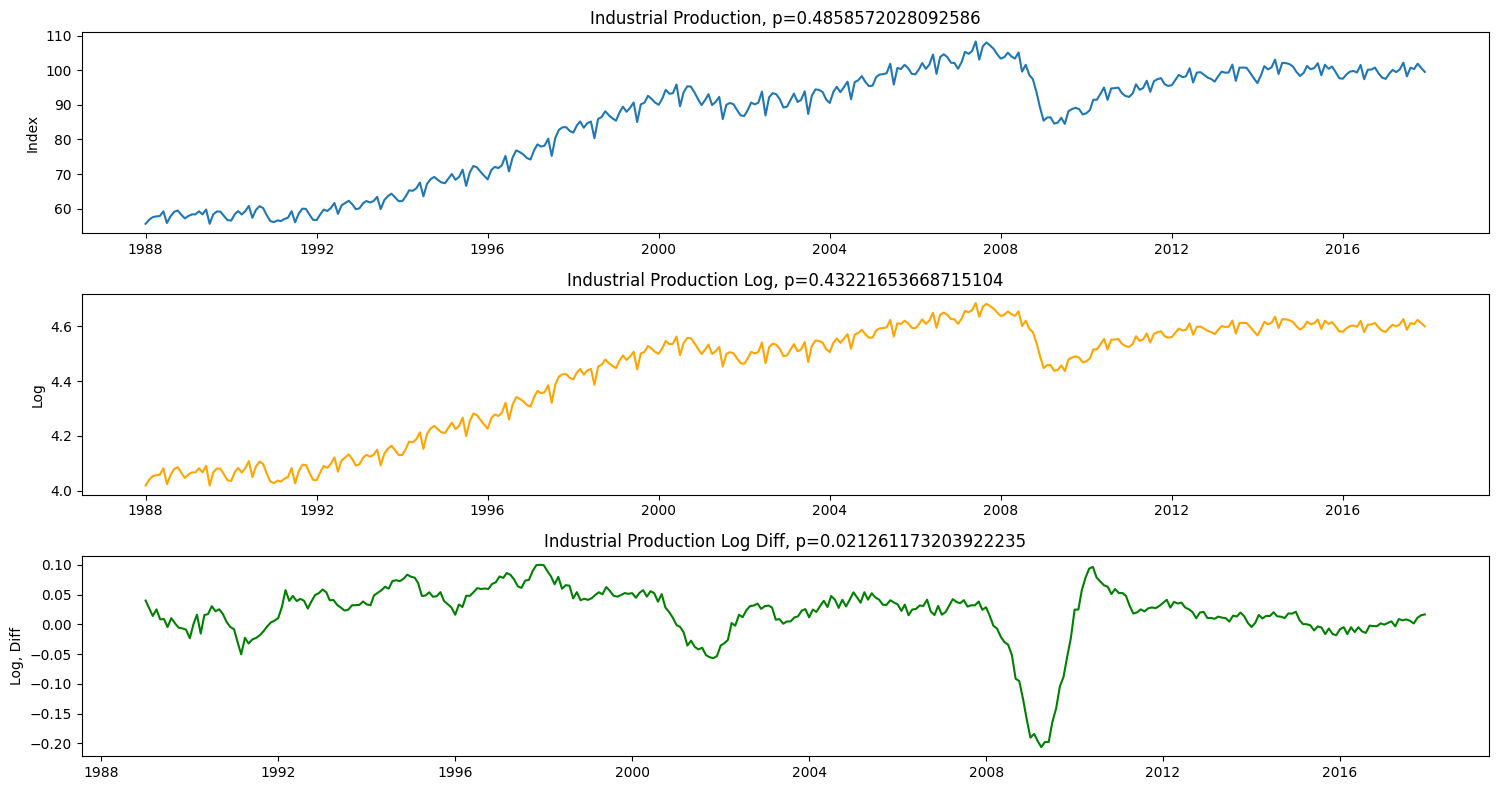

In [11]:
industrial_production_adf_p = tsa.adfuller(industrial_production)[1]
industrial_production_log_adf_p = tsa.adfuller(industrial_production_log)[1]
industrial_production_log_diff_adf_p = tsa.adfuller(industrial_production_log_diff)[1]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axs[0].plot(industrial_production)
axs[0].set_title(f"Industrial Production, p={industrial_production_adf_p}")
axs[0].set_ylabel("Index")
axs[1].plot(industrial_production_log, color="orange")
axs[1].set_title(f"Industrial Production Log, p={industrial_production_log_adf_p}")
axs[1].set_ylabel("Log")
axs[2].plot(industrial_production_log_diff, color="green")
axs[2].set_title(
    f"Industrial Production Log Diff, p={industrial_production_log_diff_adf_p}"
)
axs[2].set_ylabel("Log, Diff")
fig.tight_layout()

In [12]:
def plot_correlogram(x, nlags, title, residual_rolling=21, acf_plot_ymax=0.1):
    q_p = np.max(q_stat(acf(x, nlags=nlags), len(x))[1])
    stats = f"Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}"
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    qq_stats = f"Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}"
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    axs[0][0].plot(x)
    axs[0][0].plot(x.rolling(residual_rolling).mean(), color="black")
    axs[0][0].text(x=0.02, y=0.85, s=stats, transform=axs[0][0].transAxes)
    axs[0][0].set_title(f"Residuals and {residual_rolling}-day rolling mean")
    probplot(x, plot=axs[0][1])
    axs[0][1].text(x=0.02, y=0.75, s=qq_stats, transform=axs[0][1].transAxes)
    axs[0][1].set_title("Q-Q")
    plot_acf(x, lags=nlags, zero=False, ax=axs[1][0])
    axs[1][0].set_xlabel("Lag")
    axs[1][0].set_ylim(-acf_plot_ymax, acf_plot_ymax)
    plot_pacf(x, lags=nlags, zero=False, ax=axs[1][1])
    axs[1][1].set_xlabel("Lag")
    axs[1][1].set_ylim(-acf_plot_ymax, acf_plot_ymax)
    fig.suptitle(f"{title}")
    fig.tight_layout()

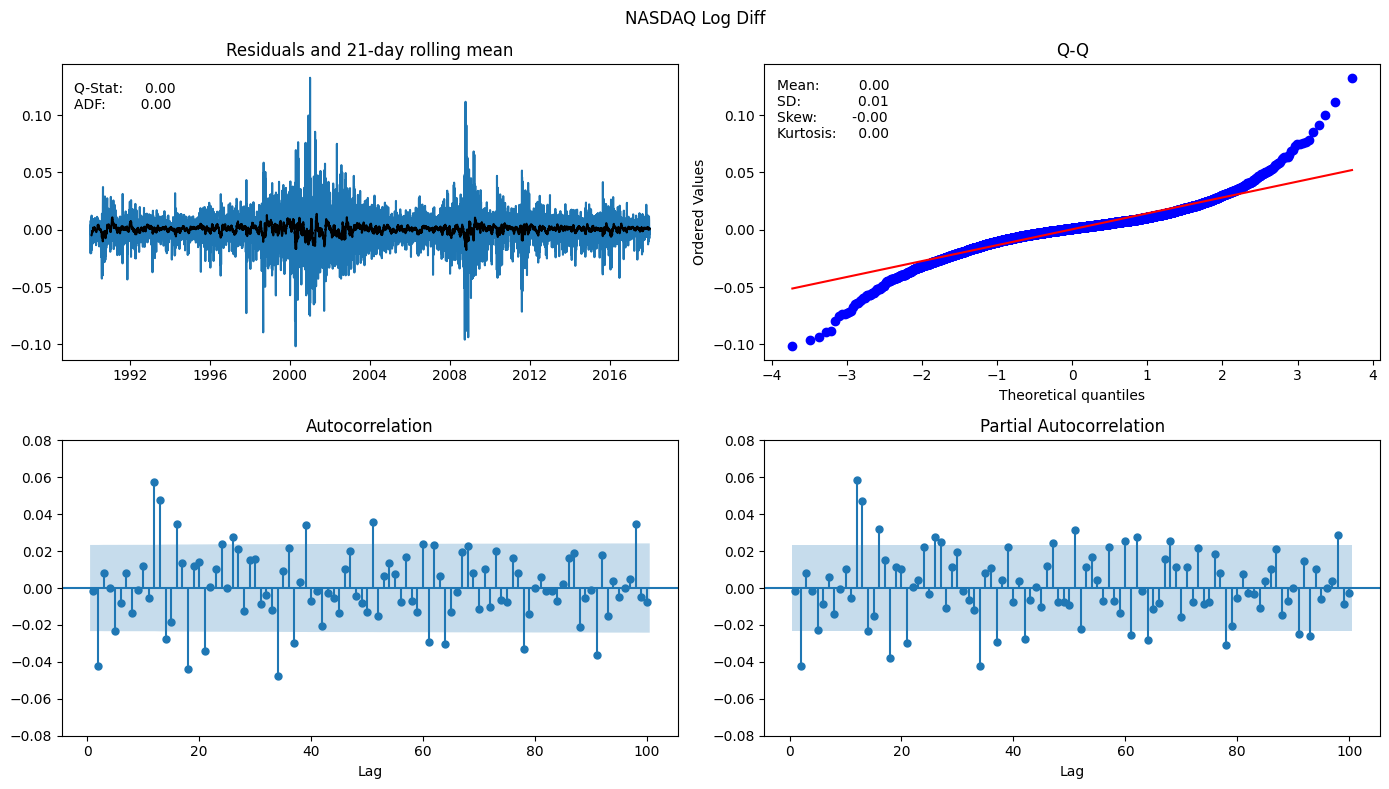

In [13]:
plot_correlogram(nasdaq_log_diff, nlags=100, title="NASDAQ Log Diff", acf_plot_ymax=0.08)

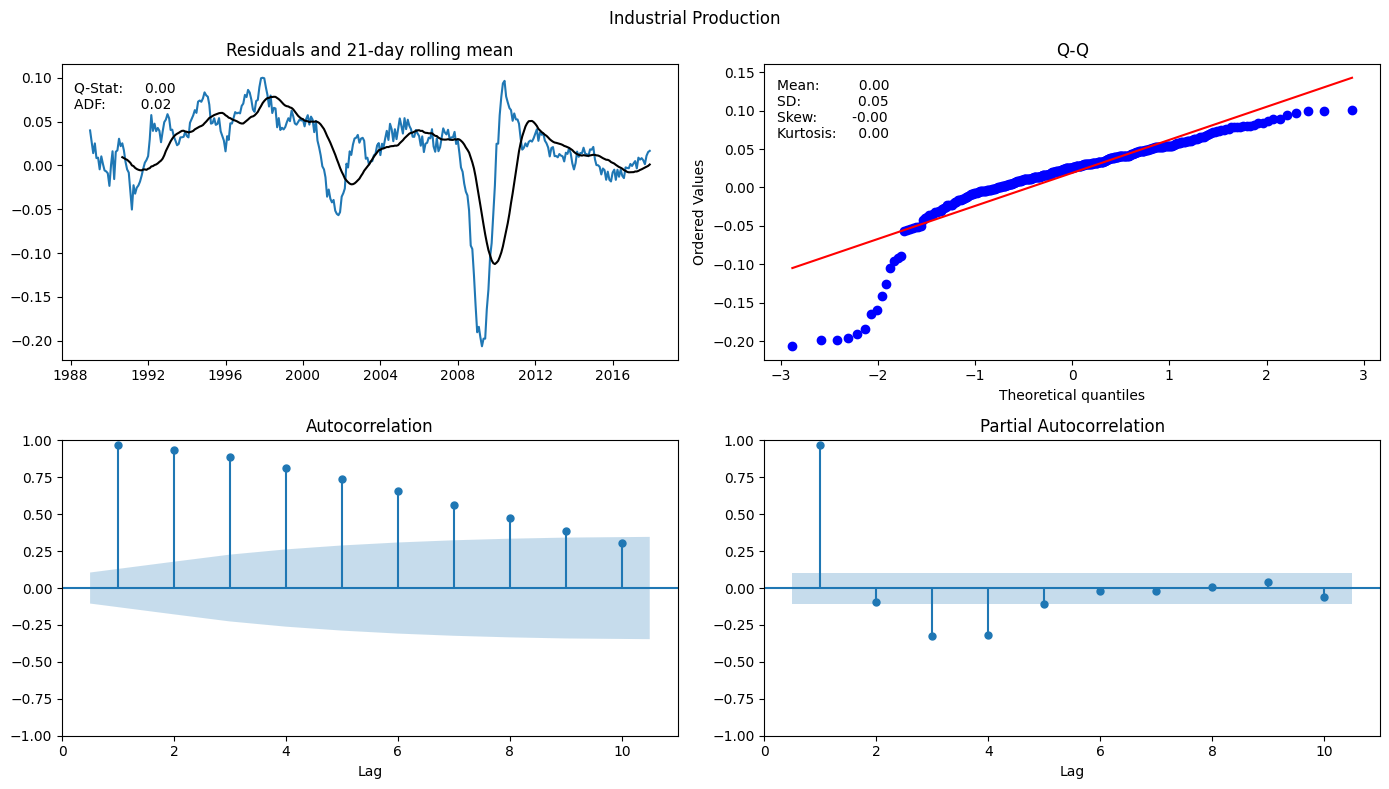

In [14]:
plot_correlogram(industrial_production_log_diff, nlags=10, title="Industrial Production", acf_plot_ymax=1.0)

## Univariate ARIMA models

### Don't just sit there, fit some models!

In [16]:
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
model3 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,1,2), seasonal_order=(0,1,0,12)).fit()
model3.params.to_frame("SARIMAX")

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX
ar.L1   0.878224
ar.L2  -0.216082
ma.L1  -0.905978
ma.L2   0.539566
sigma2  0.000107

## Search for optimal lags

In [21]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aics = []
        bics = []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p, 0, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1
            forecast = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aics.append(model.aic)
            bics.append(model.bic)
        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())
        rmse = np.sqrt(mean_squared_error(y_true=result.y_true, y_pred=result.y_pred))
        results[(p, q)] = [rmse, np.mean(aics), np.mean(bics), convergence_error, stationarity_error]

0 1


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

0 2


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

0 3


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

0 4


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

1 0


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

1 1


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

1 2


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

1 3


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

1 4


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

2 0


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

2 1


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

2 2


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

2 3


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

2 4


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

3 0


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

3 1


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

3 2


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

3 3


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

3 4


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

4 0


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

4 1


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

4 2


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

4 3


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

4 4


/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_84171/2100423510.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred.append(forecast[0])
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

In [23]:
arima_results = pd.DataFrame(results).T
arima_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arima_results.index.names = ['p', 'q']
arima_results

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.030285 -529.598751 -521.236275          0.0           0.0
  2  0.023391 -594.987570 -583.837603          0.0           0.0
  3  0.018470 -650.836120 -636.898661          0.0           0.0
  4  0.014907 -682.620139 -665.895188          0.0           0.0
1 0  0.011591 -726.193419 -717.830943          0.0           0.0
  1  0.011575 -729.029782 -717.879815          0.0           0.0
  2  0.011031 -742.047391 -728.109932          0.0           0.0
  3  0.010883 -745.453413 -728.728463          0.0           0.0
  4  0.010686 -750.612953 -731.100511          0.0           0.0
2 0  0.011554 -733.043226 -721.893259          0.0           0.0
  1  0.011962 -714.425450 -700.487991          1.0           0.0
  2  0.010176 -755.959692 -739.234742          0.0           0.0
  3  0.010114 -755.953746 -736.441304          0.0           0.0
  4  0.010258 -753.815122 -731.515188          0.0           0.0
3 0  0.010750 -746.021365 -732.083906          0.0           0.0
  1  0.010596 -746.565276 -729.840326          0.0           0.0
  2  0.010309 -754.274332 -734.761890          0.0           0.0
  3  0.010420 -753.819436 -731.519502          0.0           0.0
  4  0.010221 -753.403874 -728.316449          0.0           0.0
4 0  0.010042 -756.670778 -739.945827          0.0           0.0
  1  0.010057 -755.266418 -735.753976          0.0           0.0
  2  0.098289 -743.330028 -721.030094          0.0           0.0
  3  0.011137 -751.655392 -726.567966          0.0           0.0
  4  0.143782 -739.866606 -711.991689          0.0           0.0

In [24]:
arima_results.nsmallest(5, columns=["RMSE"])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.010042 -756.670778 -739.945827          0.0           0.0
  1  0.010057 -755.266418 -735.753976          0.0           0.0
2 3  0.010114 -755.953746 -736.441304          0.0           0.0
  2  0.010176 -755.959692 -739.234742          0.0           0.0
3 4  0.010221 -753.403874 -728.316449          0.0           0.0

In [25]:
arima_results.nsmallest(5, columns=["BIC"])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.010042 -756.670778 -739.945827          0.0           0.0
2 2  0.010176 -755.959692 -739.234742          0.0           0.0
  3  0.010114 -755.953746 -736.441304          0.0           0.0
4 1  0.010057 -755.266418 -735.753976          0.0           0.0
3 2  0.010309 -754.274332 -734.761890          0.0           0.0

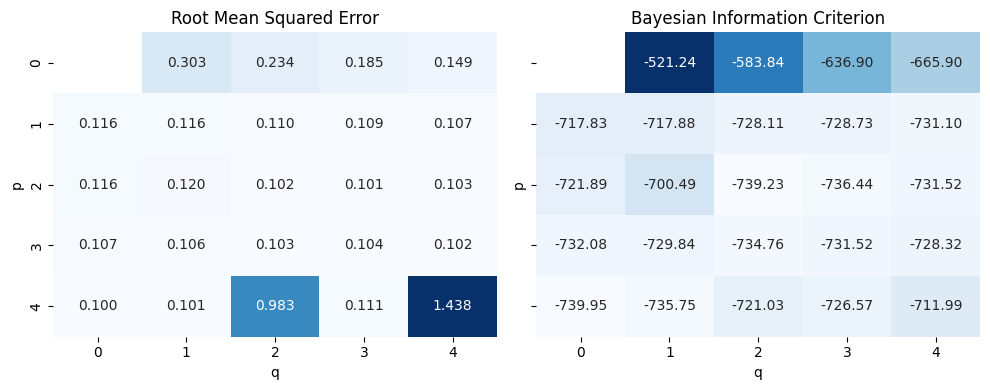

In [27]:

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arima_results[arima_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arima_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [29]:
best_p, best_q = arima_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [30]:
best_arima_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0, best_q)).fit()
print(best_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1104.627
Date:                Tue, 18 Mar 2025   AIC                          -2197.254
Time:                        14:36:31   BIC                          -2174.141
Sample:                    01-01-1989   HQIC                         -2188.052
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.010      1.880      0.060      -0.001       0.039
ar.L1          0.9335      0.044     21.051      0.000       0.847       1.020
ar.L2          0.3365      0.076      4.417      0.0

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


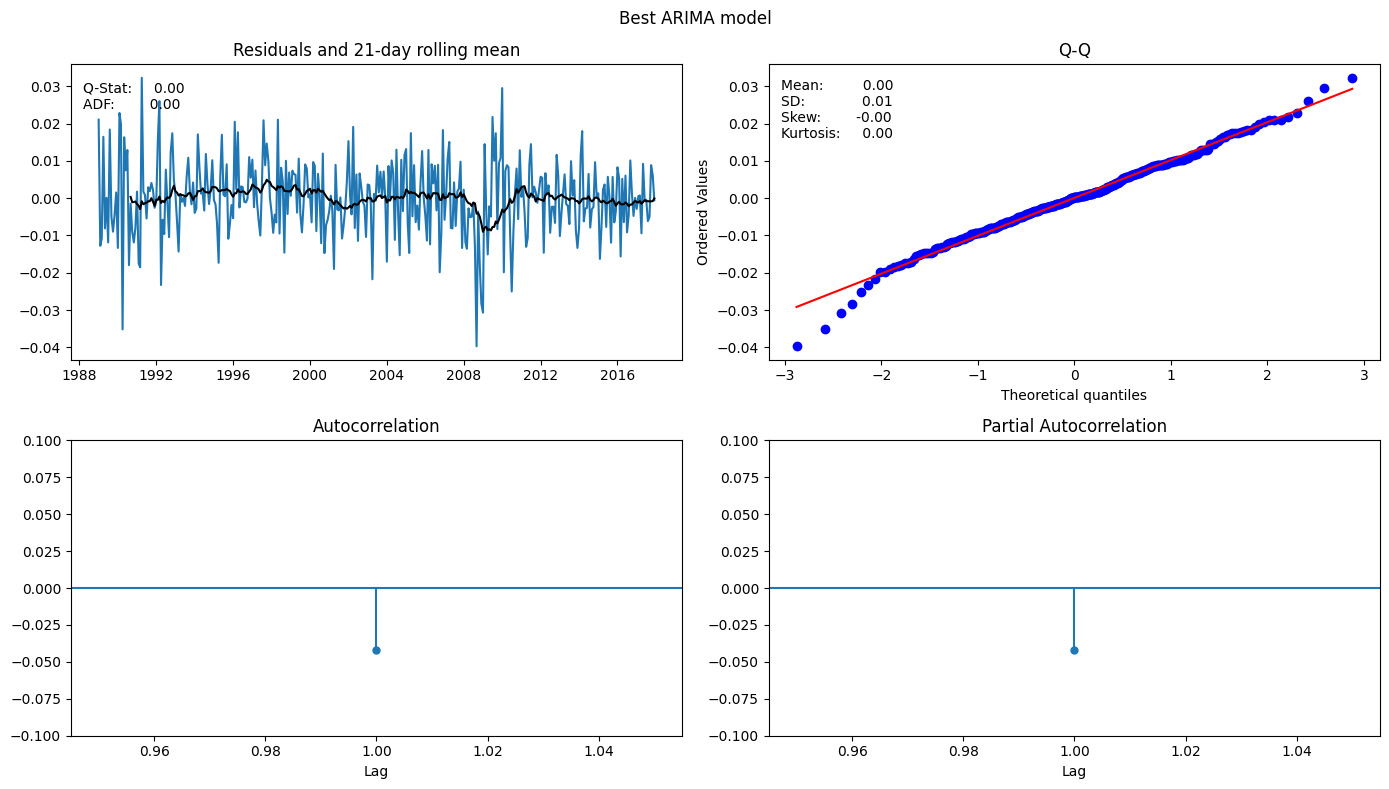

In [33]:
plot_correlogram(best_arima_model.resid, nlags=1, title="Best ARIMA model")